<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/Neural_Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyod

In [3]:
!unzip /content/drive/MyDrive/SWaT_Dataset_v0.zip -d /content/

Archive:  /content/drive/MyDrive/SWaT_Dataset_v0.zip
  inflating: /content/SWaT_Dataset_Attack_v0.csv  
  inflating: /content/SWaT_Dataset_Normal_v0.csv  


In [4]:
import numpy as np
import os
import pandas as pd
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
import pickle
import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
import pyod
import seaborn as sns

Data Pre-processing

In [5]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [6]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_attack.columns.str.replace(' ','')

In [7]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [8]:
test_df = swat_attack.set_index('Timestamp')
test_df['label'] = np.where(test_df['Normal/Attack'] == 'Attack', 1, 0)

test_df = test_df.drop('Normal/Attack', axis=1)
assert test_df.shape == (449919, 52)


train_df = swat_normal.set_index('Timestamp')
train_df['label'] = np.where(train_df['Normal/Attack'] == 'Attack', 1, 0)
train_df = train_df.drop('Normal/Attack', axis=1)

# following [Zhihan Li et al. KDD21] & [Dan Li. ICANN. 2019]
# fow SWaT data, due to the cold start of the system, starting point is 21600
train_df = train_df.iloc[21600:]


In [9]:
train_df.drop(columns = 'label',inplace = True)
label = test_df['label'].values
test_df.drop(columns = 'label',inplace = True)

In [10]:
#normalise data
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)

In [11]:
train_scale = pd.DataFrame(
    scaler.transform(train_df),
    index = train_df.index,
    columns= train_df.columns
)

test_scale  = pd.DataFrame(
    scaler.transform(test_df),
    index = test_df.index,
    columns= test_df.columns
)

In [12]:
train_scale.shape ,test_scale.shape

((475200, 51), (449919, 51))

Model Prediction

In [32]:
from  pyod.models.deep_svdd import DeepSVDD
model = DeepSVDD(preprocessing = False,epochs=20, batch_size=64 )
model.fit(train_scale)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 51)]              0         
                                                                 
 dense_4 (Dense)             (None, 64)                3264      
                                                                 
 net_output (Dense)          (None, 32)                2048      
                                                                 
 tf.math.subtract_4 (TFOpLam  (None, 32)               0         
 bda)                                                            
                                                                 
 tf.math.pow_4 (TFOpLambda)  (None, 32)                0         
                                                                 
 tf.math.reduce_sum_4 (TFOpL  (None,)                  0         
 ambda)                                                    

DeepSVDD(batch_size=64,
     c=array([0.1    , 0.1    , 0.1    , 0.3138 , 0.1    , 0.33348, 0.1    ,
       0.1    , 0.1    , 0.1    , 0.42013, 0.11639, 0.1    , 0.1    ,
       0.53865, 0.1    , 0.1    , 0.1    , 0.1    , 0.1    , 0.26927,
       0.1    , 0.3689 , 0.1    , 0.1    , 0.2921 , 0.37234, 0.1062 ,
       0.1    , 0.1    , 0.1    , 0.272  ], dtype=float32),
     contamination=0.1, dropout_rate=0.2, epochs=20,
     hidden_activation='relu', hidden_neurons=[64, 32], l2_regularizer=0.1,
     optimizer='adam', output_activation='sigmoid', preprocessing=False,
     random_state=None, use_ae=False, validation_size=0.1, verbose=1)

In [33]:
# get outlier scores
train_scores = model.decision_scores_  # raw outlier scores on the train data
test_scores = model.decision_function(test_scale)  # predict raw outlier scores on test

In [34]:
pd.DataFrame(test_scores).describe()

,0
count,4.499190e+05
mean,9.117366e+02
std,3.216740e+03
min,1.708468e-07
25%,5.222138e-03
50%,1.148563e+00
75%,3.438369e+00
max,1.329757e+04


In [35]:
pd.DataFrame(train_scores).describe()

,0
count,4.752000e+05
mean,2.573538e-03
std,2.485018e-03
min,3.700740e-08
25%,1.432917e-03
50%,1.920304e-03
75%,2.639709e-03
max,8.566771e-02


In [36]:
fpr, tpr, _ = metrics.roc_curve(label,  test_scores)
auc = metrics.roc_auc_score(label,  test_scores)

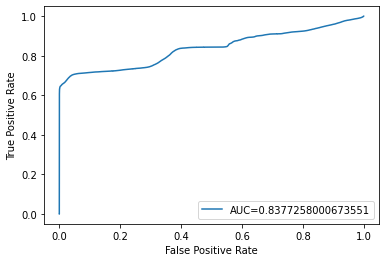

In [37]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [38]:
#normalise error score
min_train = min(train_scores)
max_train = max(train_scores)
norm_train = (train_scores-min_train)/(max_train-min_train)

In [39]:
norm_test = (test_scores - min_train)/(max_train-min_train)

In [40]:
df_error_train = pd.DataFrame(norm_train,columns = ['error'])
df_error_test = pd.DataFrame(norm_test,columns = ['error'])

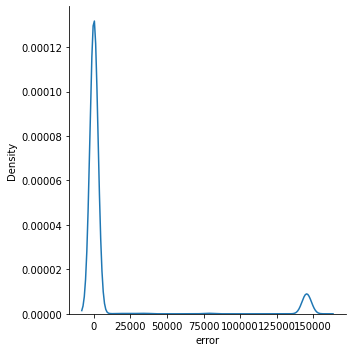

In [41]:
# sns.displot(df_error_train, x="error",kind="kde")
sns.displot(df_error_test, x="error",kind="kde")

In [42]:
threshold= np.percentile(norm_test,90)

In [43]:
threshold

59.2081024169922

In [44]:
def pred_labels_timewindow(df,threshold,time_window):
  n_data = len(df)
  pred_label = np.array([_ for _ in range(n_data)])
  for i in range(0,n_data-time_window+1):
    pred_label[i:i+time_window] = 0
    if (df[i:i+time_window] >= threshold).any():
      pred_label[i:i+time_window] = 1
  return pred_label

In [45]:
time_window = 100
pred_label = pred_labels_timewindow(norm_test,threshold,time_window)

In [46]:
print(metrics.classification_report(label,pred_label))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95    395298
           1       0.64      0.71      0.67     54621

    accuracy                           0.92    449919
   macro avg       0.80      0.83      0.81    449919
weighted avg       0.92      0.92      0.92    449919



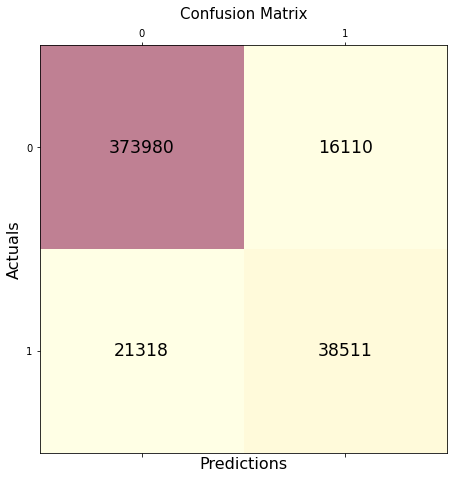

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(label,pred_label)

# Setting the attributes
fig, px = plt.subplots(figsize=(7.5, 7.5))
px.matshow(cm, cmap=plt.cm.YlOrRd, alpha=0.5)
for m in range(cm.shape[0]):
    for n in range(cm.shape[1]):
        px.text(x=m,y=n,s=cm[m, n], va='center', ha='center', size='xx-large')

# Sets the labels
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [248]:
time_label = pd.DataFrame(pred_label, index= test_df.index, columns = ['pred'])

In [249]:
time_label['label'] = label
time_label.reset_index(inplace = True)
time_label['Timestamp'] = pd.to_datetime(time_label.Timestamp)

true anomaly

In [49]:
true_anomaly = pd.read_csv("/content/drive/MyDrive/Data_sci_Project/List_of_attacks_Final.csv")

In [230]:
start_time = true_anomaly['Start Time'][~true_anomaly["End Time"].isnull()]
start_time = pd.to_datetime(start_time)
start_time.loc[36:40] = start_time.loc[36:40]+pd.DateOffset(years=1)

In [279]:
end_time = pd.to_datetime(true_anomaly['End Time'][~true_anomaly["End Time"].isnull()])

In [313]:
attack_lenght = (end_time - pd.to_datetime([str(a) for a in start_time.dt.time])).dt.seconds

In [315]:
attack_lenght

0       939
1       442
2       382
3       389
5       195
6       428
7       963
9       160
10      560
12      232
13      430
15      275
16      716
18      258
19      394
20      720
21      462
22      696
23      320
24      611
25     1444
26     1690
27    34208
28      120
29     1170
30      366
31      600
32      443
33      100
34      480
35      539
36      468
37      280
38      400
39      296
40     1674
dtype: int64

In [251]:
len(start_time) #there are 36 attack

36

In [319]:
#find start index/ end index of attack
idx_start = time_label[time_label['Timestamp'].isin(start_time)]['Timestamp'].index.values 
idx_end = idx_start+attack_lenght.values

In [391]:
time_label['attack #'] = 0
for i in range (len(idx_start)):
  time_label['attack #'].loc[idx_start[i]:idx_end[i]] = attack_lenght.index.values[i]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [516]:
time_label[(time_label['attack #'] == 27) & (time_label['pred'] == 1)]

,Timestamp,pred,label,attack #
231657,2015-12-31 02:20:57,1,1,27
231658,2015-12-31 02:20:58,1,1,27
231659,2015-12-31 02:20:59,1,1,27
231660,2015-12-31 02:21:00,1,1,27
231661,2015-12-31 02:21:01,1,1,27
...,...,...,...,...
263723,2015-12-31 11:15:23,1,1,27
263724,2015-12-31 11:15:24,1,1,27
263725,2015-12-31 11:15:25,1,1,27
263726,2015-12-31 11:15:26,1,1,27


In [517]:
time_label.loc[229500:263727]

,Timestamp,pred,label,attack #
229500,2015-12-31 01:45:00,0,1,26
229501,2015-12-31 01:45:01,0,1,26
229502,2015-12-31 01:45:02,0,1,26
229503,2015-12-31 01:45:03,0,1,26
229504,2015-12-31 01:45:04,0,1,26
...,...,...,...,...
263723,2015-12-31 11:15:23,1,1,27
263724,2015-12-31 11:15:24,1,1,27
263725,2015-12-31 11:15:25,1,1,27
263726,2015-12-31 11:15:26,1,1,27


Text(0, 0.5, 'normal/attack')

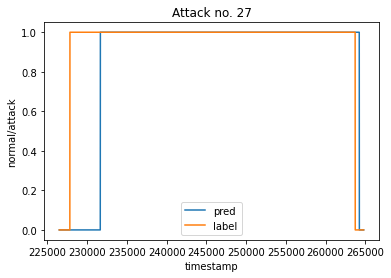

In [535]:
plt.plot(time_label.loc[226500:264800].index,time_label.loc[226500:264800]["pred"])
plt.plot(time_label.loc[226500:264800].index,time_label.loc[226500:264800]["label"])
plt.title('Attack no. 27')
plt.legend(["pred", "label"])
plt.xlabel("timestamp")
plt.ylabel("normal/attack")

Apply XAI

### Kernel SHAP

In [ ]:
!pip install shap

In [48]:
import shap

In [ ]:
shap_values50 = explainer2.shap_values((test_scale[0:50]), nsamples=500)

NameError: ignored

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values50,test_scale[0:50])

In [ ]:
%debug

In [ ]:
!pip install lime

In [537]:
import lime
import lime.lime_tabular

In [ ]:
train = train_df
train['label'] = 0

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=train.columns, class_names=['label'],
                                                   verbose=True, mode='regression',
                                                   random_state = 42)

###TCAV

In [29]:
%pip install tensorflow
%pip install tcav

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.0 MB/s 
